In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 5.12.1 GMMの必要性：k平均法の弱点

In [2]:
#データの生成
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

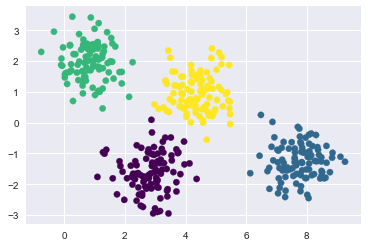

In [4]:
#K平均法でラベルを推定して表示
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

k平均法モデルはクラスタ割当の確率的または不確実性の本質的な尺度を持たない

In [6]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    #入力データのプロット
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    #k平均法モデルのプロット
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

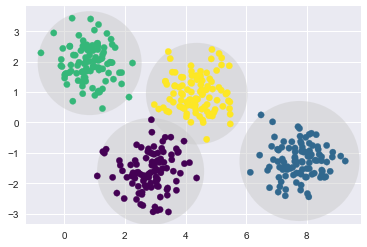

In [8]:
#k平均法モデルで示される円形クラスタ
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

k平均法には、超凹形または楕円形のクラスタを扱う方法がない。そのため同じデータに何らかの変換を施したあとでクラスタリングを行うと割当は混乱する

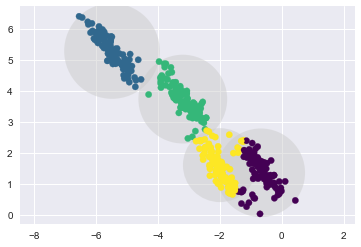

In [10]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

## 5.12.2 E-Mの一般化：ガウス混合モデル

`ガウス混合モデル(GMM Gaussian Mixture Models)`入力データセットと最もよくモデル化する多次元のガウス確率分布の重ね合わせを見つける

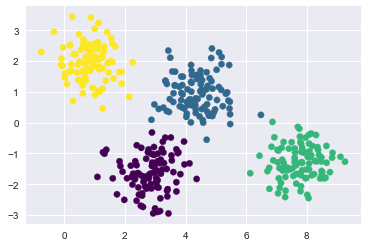

In [12]:
#データのガウス混合モデルによるラベル付け
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis');

In [14]:
#predict_proba(): サイズ[nサンプル, nクラスタ]の行列を返し、それぞれの点が各クラスタに属する行列を表す
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.537 0.463 0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [1.    0.    0.    0.   ]]


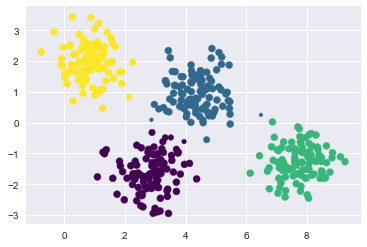

In [16]:
#確率を各点の大きさに比例させることで不確実性を可視化する
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

各クラスタは明確な境界を持つ球ではなく、滑らかなガウスモデルに関連付けられる

`期待値最大化法（E-M: Expectation-maximization`
1. クラスタ中心を推測する
2. 収束するまで繰り返す
   1. *Eステップ*：各ポイントを最近傍のクラス他中心に割り当てる
   2. *Mステップ*：各ポイントの平均をクラスタ中心に設定する

In [24]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """指定された位置と共分散より楕円を描く"""
    ax = ax or plt.gca()
    
    #共分散を主軸に変換する
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

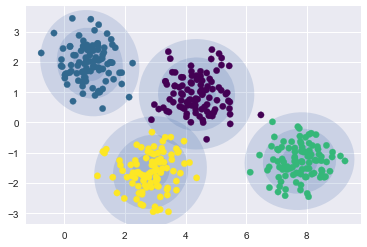

In [25]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

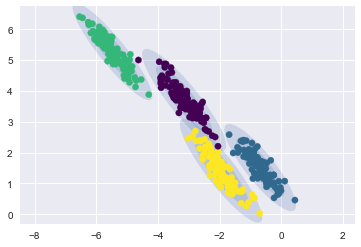

In [27]:
#covariance_typeにfullを指定すれば、非常に伸びた楕円形のクラスタにも適合する
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

### 5.12.2.1 共分散の選択

covariance_type: 各クラスタ境界の自由度を制御する。
- diag: デフォルト。各次元に沿ってクラスタのサイズを独立して設定し、結果は軸に沿った楕円になる
- spherical: 単純で高速。すべての次元が等しくなるようにクラスタの形状を成約する
- full: より複雑で計算量の必要なモデル（特に次元が増えた場合）に使用。各クラスタを任意の向きの楕円としてモデル化できる

## 5.12.3 GMMによる密度推定

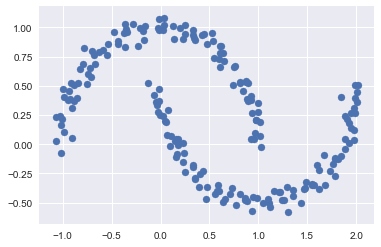

In [36]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

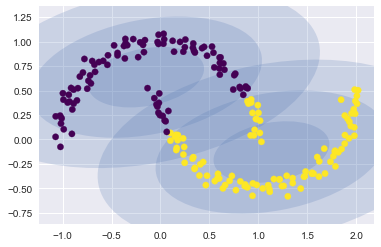

In [41]:
#2成分のクラスタリングモデルとしてGMMに適合しても有用な結果は得られない
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

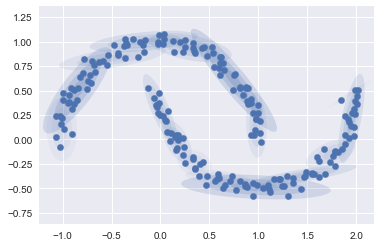

In [45]:
#2成分のクラスタリングモデルとしてGMMに適合しても有用な結果は得られない
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

分離したデータのクラスタを見つけるというよりも、入力データの全体的な分布をモデル化している

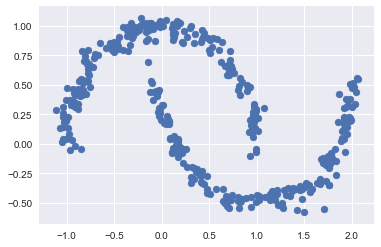

In [47]:
#16成分GMMから得られる新しいデータ
Xnew, _ = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

### 5.12.3.1 最適な成分数

生成モデルは本質的にデータセットの確率分布であるため、交差検証を使用して過剰適合を回避しながらモデルに対するデータの`尤度`を評価する

過剰適合を避けるもう1つの方法：`赤池情報量基準(AIC: Akaike Information Criterion)` や `ベイズ情報量基準(BIC: Bayesian Information Criterion)`があげられる

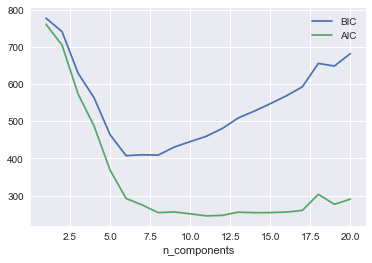

In [51]:
#GMM成分の和夫選択するためのAICとBICの可視化
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

## 5.12.4 事例：GMMによるデータの生成

In [52]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

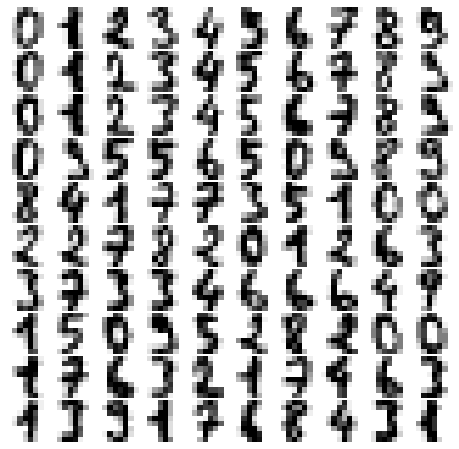

In [57]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [59]:
#分散の99%を保持する程度にPCAによって次元削減
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

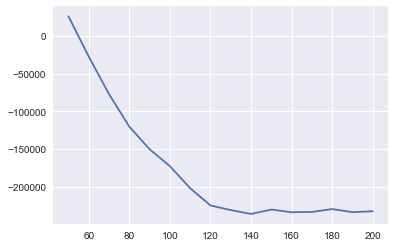

In [67]:
#AICを使用してGMM成分の数を評価（およそ110）
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [69]:
#収束することを確認
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [71]:
#41次元空間内に100個の新しいサンプルを描画
data_new, _ = gmm.sample(100)
data_new.shape

(100, 41)

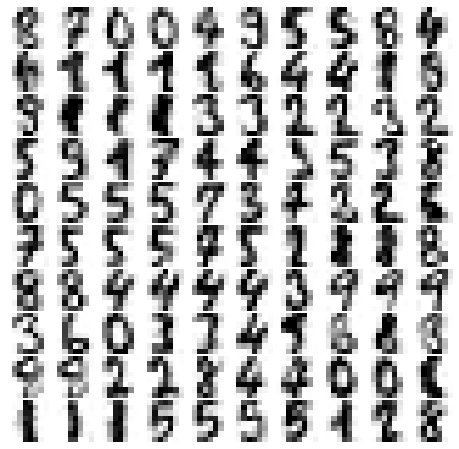

In [72]:
#PCAオブジェクトの逆変換を使用して、新しい数字を作成
digits_new=pca.inverse_transform(data_new)
plot_digits(digits_new)